In [40]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [42]:
np.random.seed(1337)
random.seed(1337)

Загрузка датасета

In [64]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=1337)
X_min = X.min(axis=0, keepdims=True)
X_max = X.max(axis=0, keepdims=True)

X = (X - X_min) / (X_max - X_min)
y = 2*y - 1

In [65]:
X.max()

np.float64(1.0)

In [66]:
X

array([[0.17323367, 0.2886664 ],
       [0.69430946, 0.23158778],
       [0.70411891, 0.75741577],
       [0.26652958, 0.32992694],
       [0.41754322, 0.30139178],
       [0.6532337 , 0.83083561],
       [0.38421088, 0.83408156],
       [0.44757063, 0.8096653 ],
       [0.16537461, 0.22221407],
       [0.49277343, 0.77454171],
       [0.42710834, 0.86459593],
       [0.25746896, 0.80698979],
       [0.57339894, 0.89688982],
       [0.45905858, 0.06949343],
       [0.23570477, 0.90103523],
       [0.39671183, 0.93489835],
       [0.70453814, 0.16811373],
       [0.27580096, 0.87095794],
       [0.09772415, 0.82145684],
       [0.54303359, 0.28206332],
       [0.67572236, 0.16547097],
       [0.58943822, 0.71012683],
       [0.54224135, 0.79254182],
       [0.43562045, 0.31769596],
       [0.30811135, 0.22321169],
       [0.39394661, 0.13510657],
       [0.3651775 , 0.24974972],
       [0.66340653, 0.2690396 ],
       [0.21192355, 0.2606179 ],
       [0.56698738, 0.15472472],
       [0.

In [67]:
y

array([-1, -1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,
        1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1, -1,
        1, -1, -1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,
        1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1])

In [68]:
X.shape

(100, 2)

In [69]:
np.unique(y)

array([-1,  1])

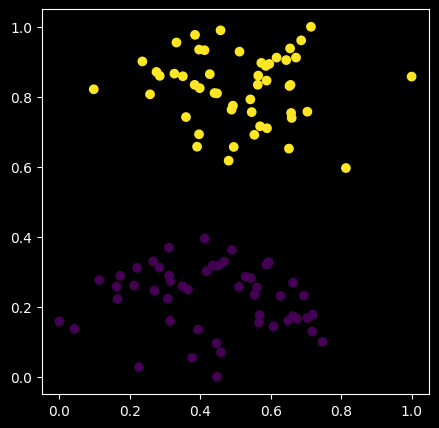

In [70]:
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=y)

In [71]:
# 2 - кол-во входов, 16 16 скрытые слои, 1 - финальная выдача классификатора
model = MLP(2, [16, 16, 1])
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


Определение функции потерь

In [72]:
def loss(batch_size = None):

    # Внутренний кастомный DataLoader
    if batch_size is None:
        Xb, yb = X, y
    else:
        # Создание случайно перемешанного массива индексов от 0 до X.shape[0], получение :batch_size первых из них
        ri = np.random.permutation(X.shape[0])[:batch_size]
        # Получение батча
        Xb = X[ri]
        yb = y[ri]

    # Применяю конструктор Value к каждой строке xrow в Xb, превращаю значения в Value
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # Forward pass инпутов через модель
    scores = list(map(model, inputs))

    # Формула функции потерь
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    # Усреднение на кол-во примеров
    data_loss = sum(losses) * (1.0 / len(losses))
    # Применение регуляризации
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # Расчет accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [73]:
# Посмотреть на примере что делает конструктор
inputs = [list(map(Value, xrow)) for xrow in X]
inputs[:5]

[[Value: data=(0.1732336656103077), Value: data=(0.2886664004549572)],
 [Value: data=(0.6943094551988868), Value: data=(0.23158778057874543)],
 [Value: data=(0.7041189060674712), Value: data=(0.7574157741610668)],
 [Value: data=(0.26652958131493776), Value: data=(0.32992694495879726)],
 [Value: data=(0.41754321781836884), Value: data=(0.3013917780727212)]]

In [74]:
# Перфоманс модели на случайной инициализации, без тюнинга параметров
total_loss, accuracy = loss()
print(total_loss, accuracy)

Value: data=(1.4803233483139404) 0.5


### Optimization loop

In [75]:
def visualize_decision_boundary():
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

step 0 loss 1.4803, accuracy 50.0%


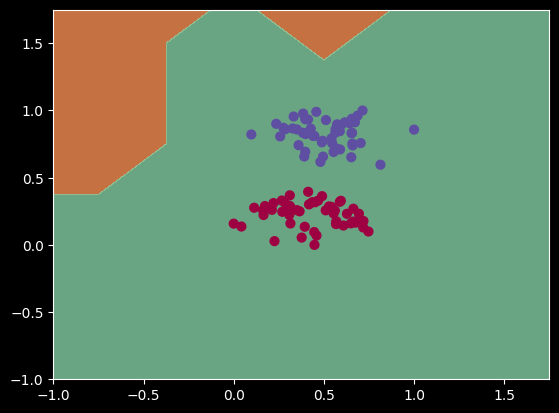

step 10 loss 0.5947, accuracy 66.0%


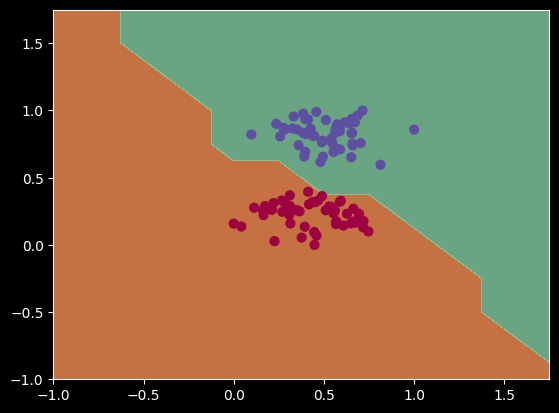

step 20 loss 0.5144, accuracy 97.0%


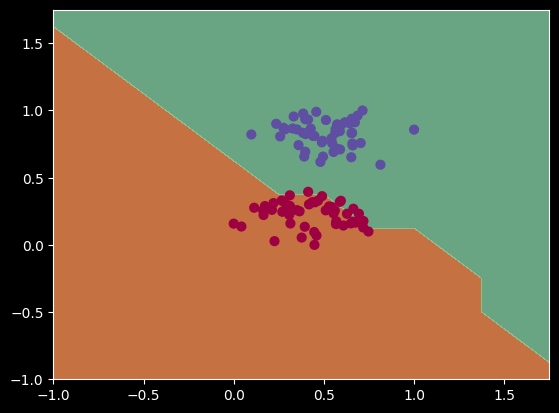

step 30 loss 0.5130, accuracy 98.0%


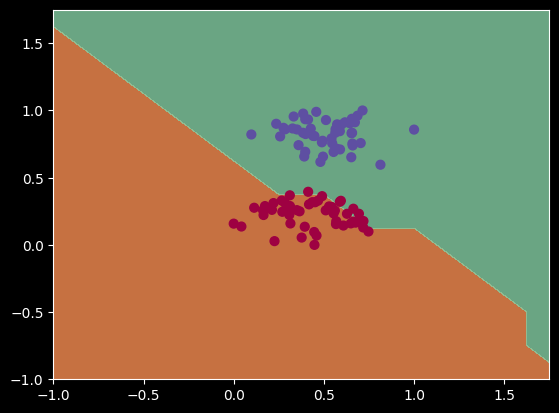

step 40 loss 0.5119, accuracy 98.0%


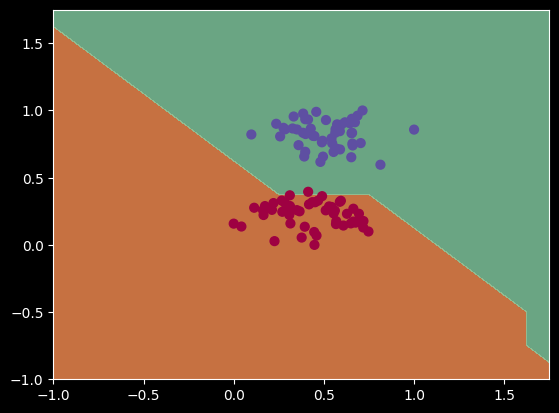

step 50 loss 0.5116, accuracy 98.0%


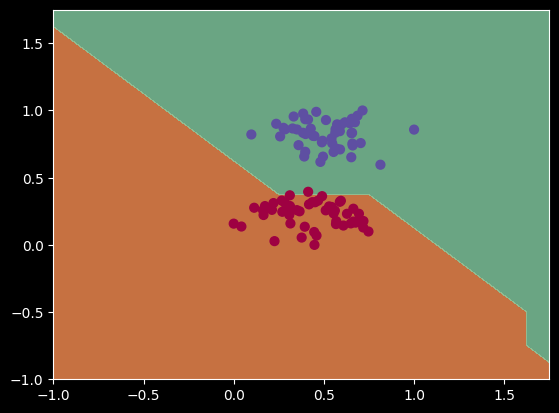

step 60 loss 0.5113, accuracy 100.0%


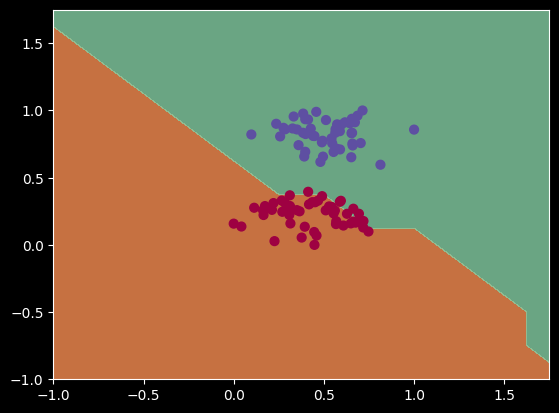

step 70 loss 0.5110, accuracy 98.0%


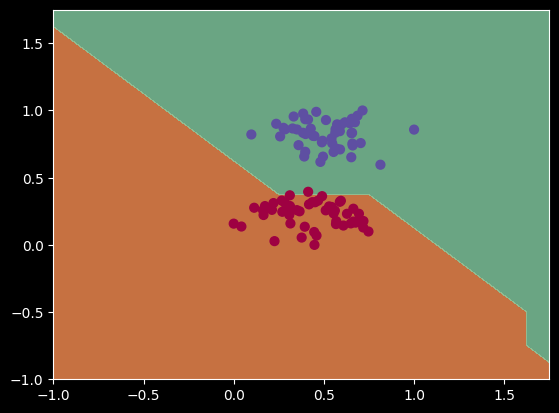

step 80 loss 0.5108, accuracy 99.0%


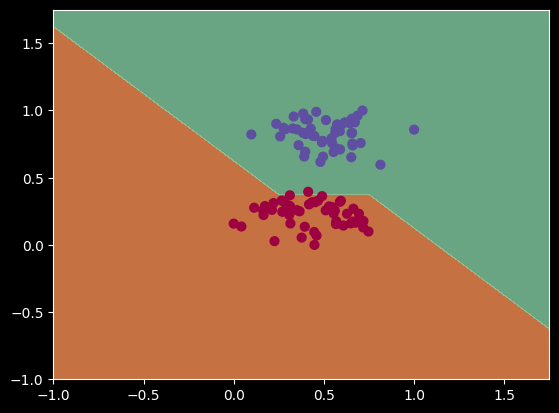

step 90 loss 0.5110, accuracy 98.0%


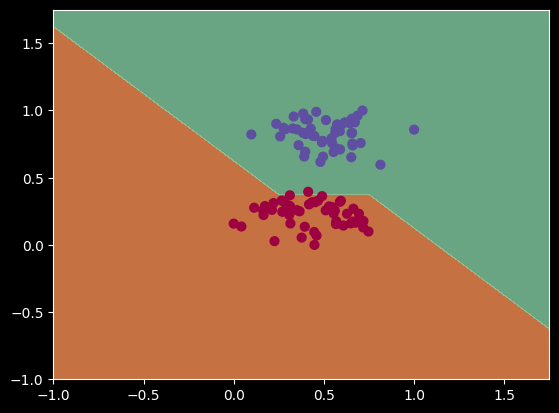

In [76]:
for k in range(100):

    total_loss, accuracy = loss()

    # Зануление градиентов
    model.zero_grad()
    # Расчет градиентов
    total_loss.backward()

    lr = 0.1
    for p in model.parameters():
        p.data -= lr * p.grad

    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data:.4f}, accuracy {accuracy*100}%")
        visualize_decision_boundary()